# Parameter Inference from 21 cm power spectra 

In [1]:
import numpy as np
from py21cmemu import Emulator

from pyPIPS.datasets import Datapoint, Dataset
emu = Emulator()

2023-05-24 12:23:49.430216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 12:23:50.939837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-24 12:23:53.068435: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
def get_21cm_ps(params):
    theta, output, output_errors = emu.predict(params)
    return Datapoint(ks=np.arange(60), zs=np.arange(12), P_kz=output["PS"], params=params)

In [3]:
dataset = Dataset()
dataset.generate_from_func(get_21cm_ps, 1000, \
                           {'F_STAR10': [0, 1], 'ALPHA_STAR': [0, 1], 'F_ESC10': [0, 1], \
                            'ALPHA_ESC': [0, 1], 'M_TURN': [0, 1], 't_STAR': [0, 1], \
                            'L_X': [0, 1], 'NU_X_THRESH': [0, 1], 'X_RAY_SPEC_INDEX': [0, 1]})

100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]


In [4]:
train, val, test = dataset.split([0.8, 0.1, 0.1])

print(train.P_kzs.shape)

100%|██████████| 100/100 [00:00<00:00, 19930.17it/s]

(800, 60, 12)


In [5]:
from pyPIPS.models import BayConvPIPS
import tensorflow as tf

model = BayConvPIPS(train)
model.generate(activation=tf.nn.tanh)
model.compile()

/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout (Conv2DFlipo  (None, 60, 12, 4)        36        
 ut)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 6, 4)         0         
 )                                                               
                                                                 
 conv2d_flipout_1 (Conv2DFli  (None, 30, 6, 8)         264       
 pout)                                                           
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 3, 8)         0         
 2D)                                                             
                                                                 
 conv2d_flipout_2 (Conv2DFli  (None, 15, 3, 16)        1

In [17]:
model.fit(epochs=100, verbose=2)

Epoch 1/100
25/25 - 0s - loss: 4.5600 - mse: 0.1589 - mae: 0.3187 - 201ms/epoch - 8ms/step
Epoch 2/100
25/25 - 0s - loss: 4.4841 - mse: 0.1575 - mae: 0.3175 - 219ms/epoch - 9ms/step
Epoch 3/100
25/25 - 0s - loss: 4.5164 - mse: 0.1554 - mae: 0.3152 - 232ms/epoch - 9ms/step
Epoch 4/100
25/25 - 0s - loss: 4.5510 - mse: 0.1547 - mae: 0.3145 - 228ms/epoch - 9ms/step
Epoch 5/100
25/25 - 0s - loss: 4.5779 - mse: 0.1580 - mae: 0.3190 - 212ms/epoch - 8ms/step
Epoch 6/100
25/25 - 0s - loss: 4.4878 - mse: 0.1561 - mae: 0.3171 - 200ms/epoch - 8ms/step
Epoch 7/100
25/25 - 0s - loss: 4.4470 - mse: 0.1582 - mae: 0.3159 - 216ms/epoch - 9ms/step
Epoch 8/100
25/25 - 0s - loss: 4.5505 - mse: 0.1626 - mae: 0.3225 - 208ms/epoch - 8ms/step
Epoch 9/100
25/25 - 0s - loss: 4.5461 - mse: 0.1538 - mae: 0.3125 - 206ms/epoch - 8ms/step
Epoch 10/100
25/25 - 0s - loss: 4.5344 - mse: 0.1550 - mae: 0.3139 - 196ms/epoch - 8ms/step
Epoch 11/100
25/25 - 0s - loss: 4.5005 - mse: 0.1608 - mae: 0.3204 - 190ms/epoch - 8ms/st

In [18]:
model.evaluate(val)

4/4 [==============================] - 0s 5ms/step - loss: 4.2226 - mse: 0.1760 - mae: 0.3341


[4.222581386566162, 0.17595309019088745, 0.3341178894042969]

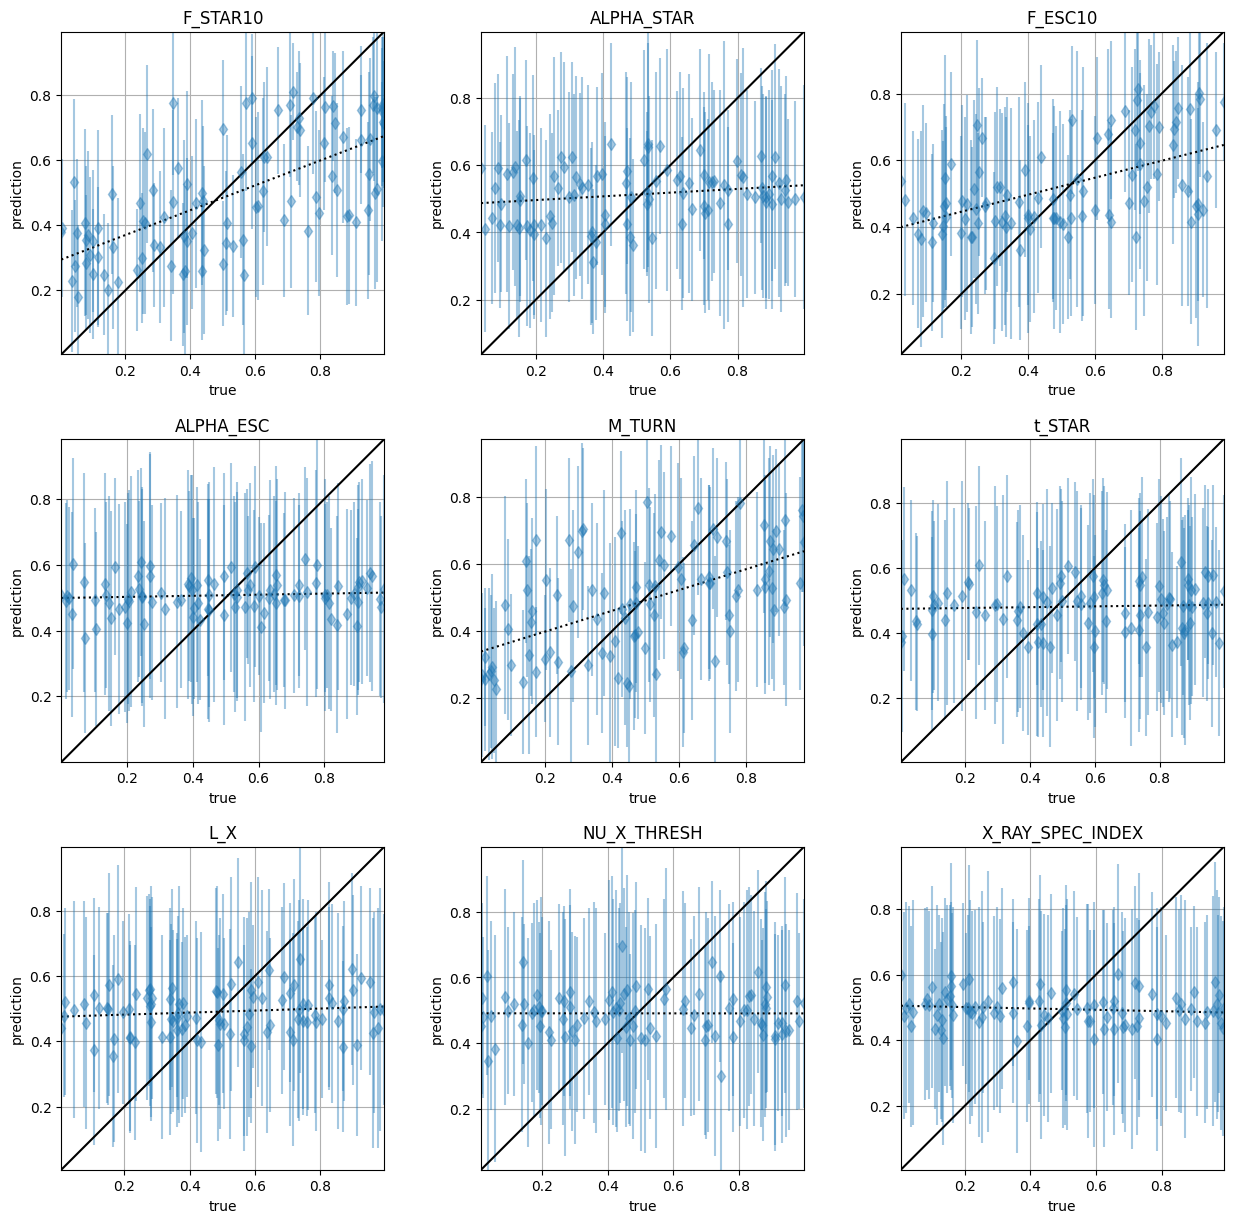

In [19]:
from matplotlib import pyplot as plt

n_pred = 50
predictions = np.empty((n_pred, *val.all_parameters.shape))
for i in range(n_pred):
    predictions[i] = model.predict(val, verbose=0)
predictions_best = np.nanmean(predictions, axis=0)
predictions_std = np.nanstd(predictions, axis=0)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = model.parameters
for ind, (label, ax) in enumerate(zip(labels, axs.ravel())):
    low_lim, upp_lim = np.min(val.all_parameters[:, ind]), np.max(val.all_parameters[:, ind])
    p = np.poly1d(np.polyfit(val.all_parameters[:, ind], predictions_best[:, ind], 1))
    ax.errorbar(val.all_parameters[:, ind], predictions_best[:, ind],  predictions_std[:, ind], marker="d", ls='none', alpha=0.4)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()